# Haqiqi 2021 2a, using pyWBM inputs

## Packages

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import dask
import os
import glob
import geopandas as gpd
import xagg as xa
from linearmodels.panel import PanelOLS

## Inputs

In [2]:
csv_output_file_haqiqi2021_2a = "/storage/home/cta5244/work/avila_et_al_2025_pyWBM_yield/data/csv_output_file_haqiqi2021_2a_normalgrowingssn_averageseason_averageyearsm.csv"
usda_filepath = "/storage/home/cta5244/work/avila_et_al_2025_pyWBM_yield/data/usda_historical_yields.csv"

In [3]:
fips_level_inputs_pd = pd.read_csv(csv_output_file_haqiqi2021_2a) 
fips_level_inputs_pd = fips_level_inputs_pd.rename(columns={'time': 'year'})
fips_level_inputs_pd['year_input'] = fips_level_inputs_pd['year']
fips_level_inputs_pd['year2'] = fips_level_inputs_pd['year']**2
usda_pd = pd.read_csv(usda_filepath)

In [31]:
usda_pd['fips'] = usda_pd['fips'].astype(str).str.zfill(5)
usda_pd['state'] = usda_pd['state'].astype(str).str.zfill(2)
usda_pd = usda_pd[['fips','year','yield', 'state']]

# Count occurrences of 'fips' and name the column 'n'
fips_counts = usda_pd.groupby('fips').size().reset_index(name='n')

# Merge the count back into the original DataFrame
usda_pd = usda_pd.merge(fips_counts, on='fips')
usda_pd = usda_pd[usda_pd["n"] >= 30]

usda_pd['log_yield'] = np.log(usda_pd['yield'])

fips_level_inputs_pd['fips'] = fips_level_inputs_pd['fips'].astype(str).str.zfill(5)
fips_level_inputs_pd['state'] = fips_level_inputs_pd['fips'].astype(str).str.slice(0, 2)

# merge usda_pd & livneh_pd 
df = fips_level_inputs_pd.merge(usda_pd, how='inner', on=['fips', 'year', 'state'])
df['year2'] = df['year']**2

rainfed_states = ["01", "05", "09", "10", "12", "13", "17", "18", "19", "20", 
                   "21", "22", "23", "24", "25", "26", "27", "28", "29", "31", 
                   "33", "34", "36", "37", "38", "39", "40", "42", "44", "45", 
                   "46", "47", "48", "50", "51", "54", "55"]

df = df[df['state'].isin(rainfed_states)]

output_dir = "/storage/home/cta5244/work/avila_et_al_2025_pyWBM_yield/0_uncertainity_figures/1_fips_pywbm_models"
os.makedirs(output_dir, exist_ok=True)
df_set_index = df.set_index(['fips', 'year'])

## Testing various models for different parameters

### Avila Model 1 (consistent with haqiqi 2021 2a)
### $logY_{i,t} = \beta_{1}GDD_{i,t} + \beta_{2}SM+ \beta_{3}SM^{2} + \beta_{\alpha}EDD_{binned} + g_{s}(t) + f_{s}(t) + c_{i} $
- no time effects, includes state specific first and second order terms as c_{i} and d_{i}
- These c_{i} & d_{i} terms are state specific, not at the county level which is consistent with lafferty et al 2021
    - That paper only includes quadratic not first order year term
- not including different intercept for each county / state
  g(s) & f(s) are year & year^2 terms for state specfific trends

In [32]:
# define the model with compound extremes & state specific trends
formula = (
    'log_yield ~ gdd + edd_minus75 + edd_minus25_75 + edd_minus25_plus25 + '
    'edd_plus25_75 + edd_plus75 + SoilM_0_100cm + SoilM_0_100cm_square + '
    'C(state):year_input + C(state):year2 + EntityEffects'
)

model = PanelOLS.from_formula(formula, data=df_set_index)
results_h21 = model.fit(cov_type='clustered', clusters=df_set_index['state'])
predictions = results_h21.predict(effects=True)
predictions['total_pred'] = predictions['fitted_values'] + predictions['estimated_effects']

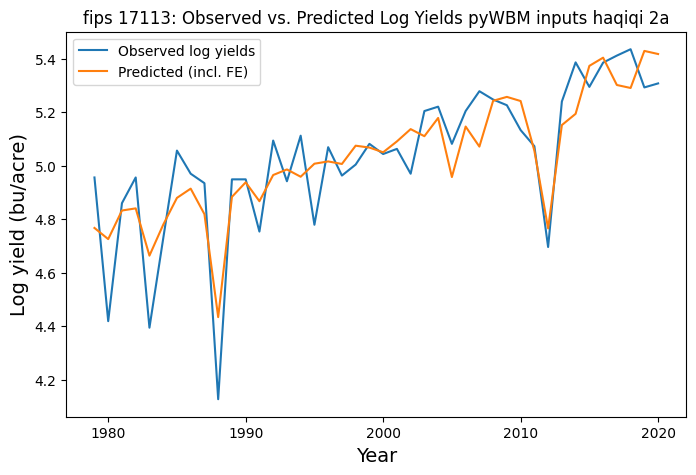

In [33]:
fips_number = '17113'
mclean_county_plot = predictions.loc[fips_number]
corn_yields = df_set_index.loc[fips_number, 'log_yield']

plt.figure(figsize=(8,5))
plt.plot(mclean_county_plot.index, corn_yields, label='Observed log yields')
plt.plot(mclean_county_plot.index, mclean_county_plot['total_pred'], label='Predicted (incl. FE)')
plt.title(f'fips {fips_number}: Observed vs. Predicted Log Yields pyWBM inputs haqiqi 2a')
plt.ylabel('Log yield (bu/acre)', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.legend()

/tmp/ipykernel_3338334/110028252.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_year['log_yield'] = usda_pd_getlevel['log_yield']


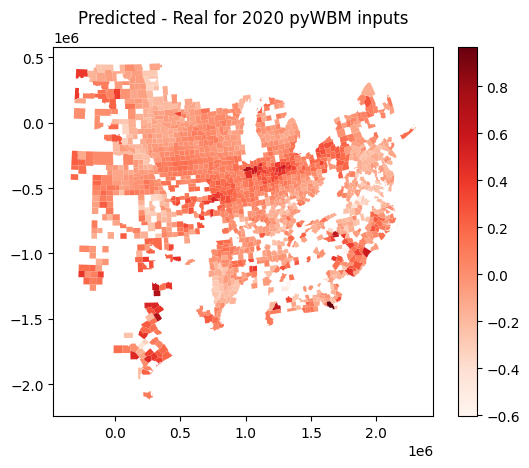

In [73]:
df_year = predictions.xs(2015, level='year') 
usda_pd_fix = usda_pd.set_index(['year', 'fips'])
usda_pd_getlevel = usda_pd_fix.xs(2015, level='year') 
df_year['log_yield'] = usda_pd_getlevel['log_yield']

df_year = df_year.reset_index()

merged = counties.merge(df_year, on='fips', how='left')
merged['bias'] = merged['total_pred'] - merged['log_yield']
merged.plot(column='bias', cmap='Reds', legend=True)

plt.title('Predicted - Real for 2020 pyWBM inputs')
plt.show()